In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import scipy.optimize as optimize
from scipy import integrate

In [2]:
#Define parameters from paper

alpha_ptc = 0.024
gamma_p = 0.006
gamma_c = 0.1539
K_h = 2.2771
k_off = 0.3018
k_on = K_h * k_off
K_p = 0.5660
n_p = 0.9
alpha_R = 0.3908
gamma_R = 0.002
K_R = 8.5184
n_R = 1.5735
alpha_GBS = 5.6881e-3
alpha_GBS0 = 9.8715e-5
D_diff = 58.3931
alpha_HH = 0.5431
gamma_H = 8.1346e-4
beta = 36
m = 1.8657

In [3]:
def create_d_matrix(n):
    h = 1/(n-1)
    D = -2*np.identity(n)
    
    for i in range(n-1):
        D[i+1, i] = 1
        D[i, i+1] = 1
        
    D[n-1] = 0
    D[0,1] = 2
    
    return D

In [4]:
def update_H(H, P, C, t):
    n = len(H)
    h = 1/(n-1)
    alpha = (D_diff*t)/(h**2)
    M = H - (gamma_H*H) - (k_on*H*P) + (k_off*C)
    M[0] += (alpha_HH/D_diff)*2*h*alpha
    Differentiation_Matrix = create_d_matrix(n)
    A = np.identity(n) - alpha*Differentiation_Matrix
    future_H = np.linalg.solve(A, M)
    
    
    for i in range(n):
        if future_H[i] < 0:
            future_H[i] = 0
    
    return future_H

def phi_R(R):
    n = len(R)
    phi = np.zeros(n)
    for i in range(n):
        phi[i] = (K_R**n_R)/((K_R**n_R)+(R[i]**n_R))
    return phi

def update_P(H, P, R, C, t):
    n = len(H)
    delta = ((alpha_ptc)*np.ones(n)) + ((alpha_ptc)*beta*phi_R(R)) - (gamma_p*P) - (k_on*H*P) + (k_off*C)
    future_P = P + delta*t
    
    for i in range(n):
        if future_P[i] < 0:
            future_P[i] = 0
    return future_P
    
def update_C(H, P, C, t):
    n = len(H)
    delta = (k_on*H*P) - (k_off*C) - (gamma_c*C)
    future_C = C + delta*t
    
    for i in range(n):
        if future_C[i] < 0:
            future_C[i] = 0
            
    return future_C

def update_R(P, R, t):
    n = len(P)
    delta = np.zeros(n)
    for i in range(n):
        delta[i] = alpha_R*((P[i]**n_p)/((K_p**n_p)+(P[i]**n_p))) - (gamma_R*R[i])
    future_R = R + delta*t
    
    for i in range(n):
        if future_R[i] < 0:
            future_R[i] = 0
            
    return future_R

def update_S(R, S, t):
    n = len(R)
    delta = ((alpha_GBS0*np.ones(n)) + (alpha_GBS*phi_R(R))) #*1000
    future_S = S + delta*t
    
    for i in range(n):
        if future_S[i] < 0:
            future_S[i] = 0
    return future_S

In [43]:
def integrate_solution(final_time, time_step, n):
    H = np.zeros(n)
    C = np.zeros(n)
    S = np.zeros(n)
    P = 5.25*np.ones(n)
    R = 172.23*np.ones(n) #188.735*np.ones(n)
    time = 0
    Hs = H[0]
    
    hrs = int(np.floor( final_time / 60)); #number of hours we will simulate over
    #make arrays to hold the values of each protein at each grid point at each hour
    H_vals = np.zeros((hrs,n));
    H_vals[0] = H; #initialize at t=0
    C_vals = np.zeros((hrs,n));
    C_vals[0] = C; #initialize at t=0
    S_vals = np.zeros((hrs,n));
    S_vals[0] = S; #initialize at t=0
    P_vals = np.zeros((hrs,n));
    P_vals[0] = P; #initialize at t=0
    R_vals = np.zeros((hrs,n));
    R_vals[0] = R; #initialize at t=0
    
    steps_each_hr = 60 / time_step + 1;
    steps = 0
    
    while time<final_time:
#         print(time)
        H = update_H(H, P, C, time_step)
        P = update_P(H, P, R, C, time_step)
        C = update_C(H, P, C, time_step)
        R = update_R(P, R, time_step)
        S = update_S(R, S, time_step)
        
        time += time_step #increment total time
        steps +=1 ;
        if steps == steps_each_hr : #we've reached an hour
            #store protein concentrations at each grid point for this hour
            index = int(time / 60);
            print("Index to insert at:", index);
            H_vals[index] = H;
            P_vals[index] = P;
            R_vals[index] = R;
            C_vals[index] = C;
            S_vals[index] = S;
            steps = 0; #reinitialize steps
        
    return H_vals, P_vals, C_vals, R_vals, S_vals;

In [44]:
from time import clock

c = clock();
hrs_to_sim = 30
H, P, C, R, S = integrate_solution(hrs_to_sim*60, 0.01, 500)
stop = clock();

print("Time: {0} min".format( (stop-c)/60 ) );

Index to insert at: 1
Index to insert at: 2
Index to insert at: 3
Index to insert at: 4
Index to insert at: 5
Index to insert at: 6
Index to insert at: 7
Index to insert at: 8
Index to insert at: 9
Index to insert at: 10
Index to insert at: 11
Index to insert at: 12
Index to insert at: 13


KeyboardInterrupt: 

In [39]:
S[29]

array([0.27022099, 0.27021427, 0.27020755, 0.27020083, 0.27019412,
       0.27018741, 0.2701807 , 0.270174  , 0.2701673 , 0.27016061,
       0.27015392, 0.27014723, 0.27014054, 0.27013386, 0.27012719,
       0.27012052, 0.27011385, 0.27010718, 0.27010052, 0.27009387,
       0.27008721, 0.27008056, 0.27007392, 0.27006727, 0.27006063,
       0.270054  , 0.27004737, 0.27004074, 0.27003411, 0.27002749,
       0.27002088, 0.27001426, 0.27000765, 0.27000105, 0.26999444,
       0.26998785, 0.26998125, 0.26997466, 0.26996807, 0.26996149,
       0.2699549 , 0.26994833, 0.26994175, 0.26993518, 0.26992862,
       0.26992205, 0.26991549, 0.26990894, 0.26990238, 0.26989583,
       0.26988929, 0.26988275, 0.26987621, 0.26986967, 0.26986314,
       0.26985661, 0.26985009, 0.26984356, 0.26983705, 0.26983053,
       0.26982402, 0.26981751, 0.26981101, 0.26980451, 0.26979801,
       0.26979152, 0.26978503, 0.26977854, 0.26977205, 0.26976557,
       0.2697591 , 0.26975262, 0.26974615, 0.26973968, 0.26973

In [40]:
S_normed = S[29] / np.max(S[29])

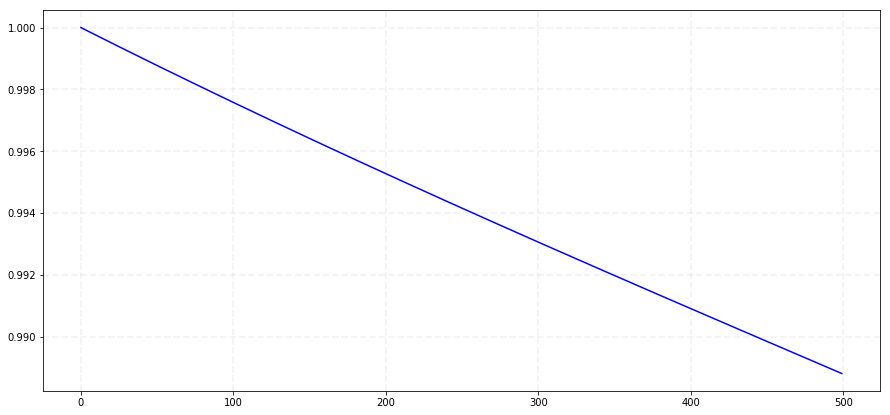

In [41]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.grid(True, lw=1.76, ls='--', alpha = 0.15)
plt.plot(S_normed, '', color = 'b')
#plt.plot(R, '', color = 'r', ms =10)
plt.show()